In [ ]:
!pip install catboost
!pip install lightgbm
!pip install fastapi uvicorn python-multipart
!pip install nest-asyncio
!pip install flask flask-ngrok pyngrok

In [ ]:
# Libraries
import pandas as pd, numpy as np, seaborn as sn, matplotlib.pyplot as plt, ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.svm import SVC
from sklearn import metrics, preprocessing
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
from sklearn.metrics import  accuracy_score, classification_report

# Function that takes a MScore and cast it into an integer value (0 means a low credit risk, 1 an high credit risk)
def MScore_to_int(x):
    return 0 if (str(x[0]).lower() in ['a', 'b']) else 1

# Function to print the overall performance metrics of a model
def print_performances(name, classifier, X_train, y_train, X_test, y_test):
    y_predict_train = classifier.predict(X_train)
    y_predict_test = classifier.predict(X_test)
    print(name + '\n - Train accuracy: ' + str(round(accuracy_score(y_train, y_predict_train) * 100, 1)) + '%')
    print(' - Test accuracy: '+ str(round(accuracy_score(y_test, y_predict_test) * 100, 1)) + '%')
    print('\nTest '+str(classification_report(y_test, y_predict_test)))

# Credit Risk Analysis - Machine Learning models <br>

The objective of this analysis is to understand which are the factors that are more effecting the probability of having an high credit risk of a given company, using initially only the data of the explanatory variables of previous year to predict the credit risk of the consequent one (true values vs forecasts). <br>
Then it can be added new explanatory variables 'delayed' e.g. leverage of two years, three years, (...) before. <br>
After understood some general behavior (through the previous notebook), this specific notebook has the objective to build different models to predict the credit risk level (low/high) in an year for each company, and also compare each presented model (in order to both interpret them and see their accuracy).

## Import the dataset & data manipulations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
clean_df = pd.read_csv('cleaned-credit-risk.tar.gz', compression='gzip')
clean_df

In [ ]:
# Load the datatset
companies_df = pd.read_csv('/content/drive/My Drive/Astranauts/datasets/1/one-hot-credit-risk.tar.gz', compression='gzip')
companies_df

,Company name,Turnover.2020,Turnover.2019,Turnover.2018,Turnover.2017,Turnover.2016,Turnover.2015,EBIT.2020,EBIT.2019,EBIT.2018,EBIT.2017,EBIT.2016,EBIT.2015,PLTax.2020,PLTax.2019,PLTax.2018,PLTax.2017,PLTax.2016,PLTax.2015,MScore.2020,MScore.2019,MScore.2018,MScore.2017,MScore.2016,MScore.2015,Region,Country,NACE code,Sector 1,Sector 2,Leverage.2020,Leverage.2019,Leverage.2018,Leverage.2017,Leverage.2016,Leverage.2015,ROE.2020,ROE.2019,ROE.2018,ROE.2017,ROE.2016,ROE.2015,TAsset.2020,TAsset.2019,TAsset.2018,TAsset.2017,TAsset.2016,TAsset.2015,MScore.2020.int,MScore.2019.int,MScore.2018.int,MScore.2017.int,MScore.2016.int,MScore.2015.int,France,Germany,Italy,Spain,Automobiles and Components,Capital Goods,Commercial and professional services,Consumer Durables and Apparel,Consumer Services,Diversified Financials,Energy,Food Beverage and Tobacco,Food and Staples Retailing,Health Care Equipment and Services,Household and Personal Products,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities
0,LENDLEASE S.R.L.,29458,16716,9612,8097,7941.0,5600.0,-1556.0,-4540.0,623.0,-412.0,885.0,-1479.0,-1402.0,-4674.0,22.0,-360.0,368.0,-1140.0,CC,CC,CCC,C,BB,C,Milano,Italy,4200,Civil engineering,Capital Goods,14.33,9.90,56.77,64.15,21.46,48.07,-43.63,-180.22,8.24,-146.65,60.76,-471.72,49263,28268,15455,15992,13597.0,11659.0,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,PRICEWATERHOUSECOOPERS BUSINESS SERVICES SRL (...,16731,16403,16843,12241,9252.0,9515.0,1838.0,841.0,2738.0,-864.0,-2212.0,-3572.0,1600.0,700.0,2577.0,-900.0,-2187.0,-4591.0,A,BBB,BBB,CC,CCC,CCC,Milano,Italy,7022,Activities of head offices; management consult...,Commercial and professional services,1.86,2.45,2.92,5.65,2.90,1.29,27.60,14.30,61.42,-55.57,-127.29,-87.13,16550,16887,16468,10773,6697.0,8933.0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EVISO S.P.A.,48568,43039,34302,25791,19760.0,6941.0,1661.0,1464.0,976.0,495.0,162.0,224.0,1159.0,1047.0,779.0,267.0,63.0,123.0,BBB,BBB,BBB,BB,BB,BB,Cuneo,Italy,3514,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING S...",Utilities,3.59,3.49,4.44,7.69,12.54,9.39,39.38,48.89,57.52,42.73,20.34,44.62,13500,9620,7371,5432,4170.0,2862.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,CASA SERVICE MACHINE,47999,43484,43043,41682,51267.0,52584.0,416.0,255.0,-855.0,-23.0,426.0,969.0,236.0,107.0,-1002.0,-197.0,430.0,602.0,BB,B,CCC,B,BB,BB,Pas-de-Calais,France,4661,"Wholesale trade, except of motor vehicles and ...",Retailing,3.54,3.89,4.15,2.64,3.21,3.18,8.42,5.69,-17.24,0.71,2.89,6.45,24978,25032,25729,21632,25403.0,24941.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,PANFERTIL SPA,45948,47336,45626,48222,57074.0,62263.0,44.0,713.0,-672.0,-1091.0,97.0,987.0,3.0,48.0,-599.0,-821.0,-10.0,-1116.0,B,BB,CCC,CCC,B,B,Ravenna,Italy,4675,"Wholesale trade, except of motor vehicles and ...",Retailing,2.17,1.98,2.13,2.15,2.15,2.11,0.03,0.41,-5.17,-6.74,0.03,-8.19,36823,34659,36205,38423,41847.0,41323.0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121003,ASTOR VILLAGE S.R.L.,3161,4635,4742,4499,4277.0,3650.0,985.0,1818.0,1790.0,1248.0,1154.0,800.0,739.0,1185.0,1283.0,875.0,744.0,494.0,AA,AA,AA,AA,A,A,Lecce,Italy,5510,Accommodation,Consumer Services,0.17,0.22,0.24,0.26,0.29,0.34,5.44,9.23,11.01,8.44,7.83,6.31,15935,15664,14438,13054,12243.0,11695.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121004,ODONE & SLOA S.R.L.,3161,2562,2559,2334,3692.0,2537.0,60.0,101.0,27.0,10.0,9.0,74.0,21.0,6.0,1.0,-4

### Balancing the companies (use same number for high and low level credit risk)

In [ ]:
# Fix the unbalanced case
high_risk_df = companies_df[companies_df['MScore.2019.int'] == 1]
low_risk_df = companies_df[companies_df['MScore.2019.int'] == 0].sample(n=len(high_risk_df), random_state=0)
restricted_df = pd.concat([low_risk_df, high_risk_df])
restricted_df.sort_index(inplace=True)

## Consider past year company data to predict next year credit risk level

### Select the year to use to predict the consequent one credit risk level

**Beware of the year choice**, because of the already mentioned Covid (possible) effect.

In [ ]:
year_widget = widgets.IntSlider(value=2018, min=2015, max=2019, description='Year:', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
year_widget

IntSlider(value=2018, description='Year:', max=2019, min=2015)

### First objective: feature selection

Once found the most impactful features we will see whether considering other more complex models (mantaining fixed the features) the performance metrics will change signficantly (or not).

#### Easiest model: credit risk level of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int']]
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int
0,1
4,1
7,0
11,0
16,0
...,...
120994,0
120995,1
120998,0
121003,0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



**Consideration:** The overall obtained performances can be considered good, but what if we add and consider other features?<br>

#### Add another feature: credit risk level + turnover of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Turnover.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Turnover.2018
0,1.0,0.158884
1,1.0,0.912978
2,0.0,0.856485
3,0.0,0.701328
4,0.0,0.641379
...,...,...
24315,0.0,0.032581
24316,1.0,0.048264
24317,0.0,0.026216
24318,0.0,0.056912


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk score + EBIT of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'EBIT.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,EBIT.2018
0,1.0,0.777574
1,1.0,0.772238
2,0.0,0.791195
3,0.0,0.776359
4,0.0,0.790593
...,...,...
24315,0.0,0.775291
24316,1.0,0.775386
24317,0.0,0.776107
24318,0.0,0.782384


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + PLTax of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'PLTax.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,PLTax.2018
0,1.0,0.809337
1,1.0,0.806730
2,0.0,0.821109
3,0.0,0.809904
4,0.0,0.820282
...,...,...
24315,0.0,0.809366
24316,1.0,0.809299
24317,0.0,0.810130
24318,0.0,0.814631


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level of previous year + country, to predict the one of next year

In [ ]:
X = pd.concat([restricted_df[['MScore.'+str(year_widget.value)+'.int']], restricted_df.loc[:, 'France':'Spain']], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,France,Germany,Italy,Spain
0,1,0,0,1,0
4,1,0,0,1,0
7,0,0,0,1,0
11,0,1,0,0,0
16,0,0,0,1,0
...,...,...,...,...,...
120994,0,0,0,1,0
120995,1,0,0,1,0
120998,0,1,0,0,0
121003,0,0,0,1,0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level of previous year + general sector, to predict the one of next year

In [ ]:
X = pd.concat([restricted_df[['MScore.'+str(year_widget.value)+'.int']], restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Automobiles and Components,Capital Goods,Commercial and professional services,Consumer Durables and Apparel,Consumer Services,Diversified Financials,Energy,Food Beverage and Tobacco,Food and Staples Retailing,Health Care Equipment and Services,Household and Personal Products,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120994,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120995,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
120998,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121003,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + Leverage of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Leverage.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Leverage.2018
0,1.0,0.086342
1,1.0,0.086212
2,0.0,0.086208
3,0.0,0.086215
4,0.0,0.086213
...,...,...
24315,0.0,0.086229
24316,1.0,0.086246
24317,0.0,0.086209
24318,0.0,0.086208


In [ ]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + ROE of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'ROE.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,ROE.2018
0,1.0,0.152948
1,1.0,0.152937
2,0.0,0.152946
3,0.0,0.152954
4,0.0,0.152966
...,...,...
24315,0.0,0.152947
24316,1.0,0.152946
24317,0.0,0.152980
24318,0.0,0.152950


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Add another feature: credit risk level + TAsset of previous year, to predict the one of next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'TAsset.'+str(year_widget.value)]]
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,TAsset.2018
0,1.0,0.007275
1,1.0,0.017136
2,0.0,0.031393
3,0.0,0.005507
4,0.0,0.014624
...,...,...
24315,0.0,0.001933
24316,1.0,0.001715
24317,0.0,0.000322
24318,0.0,0.006792


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.3%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



#### Combine all features together: credit risk level + Turnover + EBIT + PLTax + Sector + Country + Leverage + ROE + TAsset of previous year, to predict the one of the next year

In [ ]:
X = restricted_df[['MScore.'+str(year_widget.value)+'.int', 'Turnover.'+str(year_widget.value), 'EBIT.'+str(year_widget.value), 'PLTax.'+str(year_widget.value), 'Leverage.'+str(year_widget.value), 'ROE.'+str(year_widget.value), 'TAsset.'+str(year_widget.value)]]
X = pd.concat([X, restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'France':'Spain']], axis=1)
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2018.int,Turnover.2018,EBIT.2018,PLTax.2018,Leverage.2018,ROE.2018,TAsset.2018,Automobiles and Components,Capital Goods,Commercial and professional services,Consumer Durables and Apparel,Consumer Services,Diversified Financials,Energy,Food Beverage and Tobacco,Food and Staples Retailing,Health Care Equipment and Services,Household and Personal Products,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities,France,Germany,Italy,Spain
0,1.0,0.158884,0.777574,0.809337,0.086342,0.152948,0.007275,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.912978,0.772238,0.806730,0.086212,0.152937,0.017136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.856485,0.791195,0.821109,0.086208,0.152946,0.031393,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.701328,0.776359,0.809904,0.086215,0.152954,0.005507,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.641379,0.790593,0.820282,0.086213,0.152966,0.014624,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24315,0.0,0.032581,0.775291,0.809366,0.086229,0.152947,0.001933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24316,1.0,0.048264,0.775386,0.809299,0.086246,0.152946,0.001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24317,0.0,0.026216,0.776107,0.810130,0.086209,0.152980,0.000322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24318,0.0,0.056912,0.782384,0.814631,0.086208,0.152950,0.006792,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 78.7%
 - Test accuracy: 79.4%

Test               precision    recall  f1-score   support

           0       0.72      0.96      0.82      2432
           1       0.94      0.63      0.75      2432

    accuracy                           0.79      4864
   macro avg       0.83      0.79      0.79      4864
weighted avg       0.83      0.79      0.79      4864



## Consider also older than one year company data to predict consequent year credit risk level

### Models

#### All past years credit risk levels to predict the one of the next year

In [ ]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int']]], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,MScore.2016.int,MScore.2017.int,MScore.2018.int
0,1,0,1,1
4,0,0,1,1
7,0,0,0,0
11,0,0,0,0
16,0,0,0,0
...,...,...,...,...
120994,1,1,0,0
120995,1,1,1,1
120998,0,0,0,0
121003,0,0,0,0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 81.5%
 - Test accuracy: 82.4%

Test               precision    recall  f1-score   support

           0       0.77      0.91      0.84      2432
           1       0.89      0.73      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



#### All features together: credit risk level + Turnover + EBIT + PLTax + Sector + Country + Leverage + ROE + TAsset of also past years, to predict the one of the next year

In [ ]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int', 'Turnover.2015', 'EBIT.2015', 'PLTax.2015', 'Leverage.2015', 'ROE.2015', 'TAsset.2015']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int', 'Turnover.'+str(2015 + i), 'EBIT.'+str(2015 + i), 'PLTax.'+str(2015 + i), 'Leverage.'+str(2015 + i), 'ROE.'+str(2015 + i), 'TAsset.'+str(2015 + i)]]], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'Automobiles and Components':'Utilities']], axis=1)
X = pd.concat([X, restricted_df.loc[:, 'France':'Spain']], axis=1)
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns) # MinMax Scaling
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,Turnover.2015,EBIT.2015,PLTax.2015,Leverage.2015,ROE.2015,TAsset.2015,MScore.2016.int,Turnover.2016,EBIT.2016,PLTax.2016,Leverage.2016,ROE.2016,TAsset.2016,MScore.2017.int,Turnover.2017,EBIT.2017,PLTax.2017,Leverage.2017,ROE.2017,TAsset.2017,MScore.2018.int,Turnover.2018,EBIT.2018,PLTax.2018,Leverage.2018,ROE.2018,TAsset.2018,Automobiles and Components,Capital Goods,Commercial and professional services,Consumer Durables and Apparel,Consumer Services,Diversified Financials,Energy,Food Beverage and Tobacco,Food and Staples Retailing,Health Care Equipment and Services,Household and Personal Products,Materials,Media & Entertainment,Pharmaceuticalcs biotechnology and life sci,Real Estate,Retailing,Software and Services,Technology Hardware and Equipment,Telecommunication Services,Transportation,Utilities,France,Germany,Italy,Spain
0,1.0,0.026555,0.567529,0.577861,0.001091,0.878438,0.005735,0.0,0.029056,0.302037,0.389655,0.002107,0.261104,0.006821,1.0,0.126993,0.394622,0.585090,0.156514,0.067185,0.008106,1.0,0.158884,0.777574,0.809337,0.086342,0.152948,0.007275,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.295250,0.575646,0.577941,0.001087,0.878846,0.020328,0.0,0.208834,0.299928,0.388763,0.002104,0.260981,0.020991,1.0,0.963296,0.391783,0.583593,0.156099,0.067713,0.019587,1.0,0.912978,0.772238,0.806730,0.086212,0.152937,0.017136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.111328,0.579888,0.586102,0.001087,0.878858,0.031902,0.0,0.162903,0.310055,0.394763,0.002104,0.260992,0.034901,0.0,0.891994,0.413287,0.595372,0.156087,0.067759,0.037054,0.0,0.856485,0.791195,0.821109,0.086208,0.152946,0.031393,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.127450,0.572621,0.581604,0.001087,0.878888,0.003837,0.0,0.113188,0.300696,0.389407,0.002105,0.261029,0.005258,0.0,0.691198,0.398075,0.587212,0.156112,0.067800,0.005952,0.0,0.701328,0.776359,0.809904,0.086215,0.152954,0.005507,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.088964,0.577920,0.584856,0.001087,0.878875,0.010428,0.0,0.072324,0.304515,0.391323,0.002105,0.261024,0.013510,0.0,0.473332,0.405248,0.590574,0.156109,0.067817,0.015261,0.0,0.641379,0.790593,0.820282,0.086213,0.152966,0.014624,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24315,1.0,0.020372,0.571538,0.580967,0.001087,0.878830,0.002160,1.0,0.015203,0.299668,0.388572,0.002106,0.260931,0.002318,0.0,0.041810,0.396900,0.586338,0.156150,0.067761,0.002097,0.0,0.032581,0.775291,0.809366,0.086229,0.152947,0.001933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24316,1.0,0.020191,0.572749,0.581634,0.001088,0.878856,0.001881,1.0,0.015759,0.299949,0.388805,0.002107,0.260989,0.001898,1.0,0.047958,0.396712,0.586283,0.156199,0.067751,0.001802,1.0,0.048264,0.775386,0.809299,0.086246,0.152946,0.001715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24317,0.0,0.014297,0.573039,0.582162,0.001087,0.878879,0.000568,0.0,0.011248,0.300147,0.389112,0.002104,0.261040,0.000502,0.0,0.023156,0.397096,0.586737,0.156093,0.067853,0.000406,0.0,0.026216,0.776107,0.810130,0.086209,0.152980,0.000322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24318,0.0,0.017308,0.575030,0.583288,0.001087,0.878859,0.005753,0.0,0.015650,0.302757,0.390542,0.002104,0.260997,0.006141,0.0,0.052002,0.401561,0.589102,0.156086,0.067770,0.006602,0.0,0.056912,0.782384,0.814631,0.086208,0.152950,0.006792,0.0,0.0,

In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 81.4%
 - Test accuracy: 82.1%

Test               precision    recall  f1-score   support

           0       0.77      0.92      0.84      2432
           1       0.90      0.72      0.80      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



## Other models

### Recap: best features (Logistic Regression)

In [ ]:
for i in range(0, year_widget.value - 2014):
    if i == 0: X = restricted_df[['MScore.2015.int']]
    else: X = pd.concat([X, restricted_df[['MScore.'+str(2015 + i)+'.int']]], axis=1)
y = restricted_df[['MScore.'+str(year_widget.value + 1)+'.int']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True, stratify=y)
X

,MScore.2015.int,MScore.2016.int,MScore.2017.int,MScore.2018.int
0,1,0,1,1
4,0,0,1,1
7,0,0,0,0
11,0,0,0,0
16,0,0,0,0
...,...,...,...,...
120994,1,1,0,0
120995,1,1,1,1
120998,0,0,0,0
121003,0,0,0,0


In [ ]:
xgb = XGBClassifier(booster='gblinear', random_state=255)
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 81.5%
 - Test accuracy: 82.4%

Test               precision    recall  f1-score   support

           0       0.77      0.91      0.84      2432
           1       0.89      0.73      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



#### Features importance

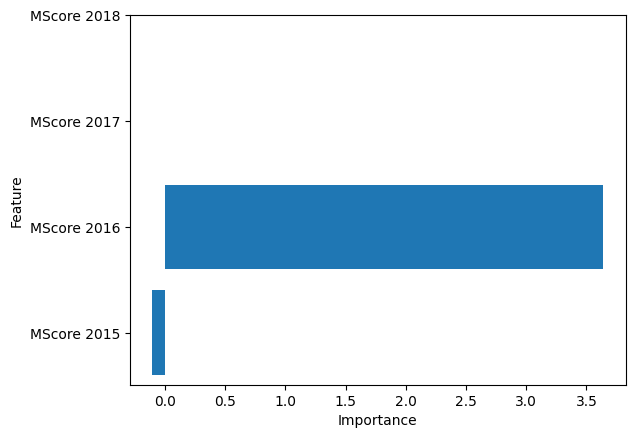

In [ ]:
importance = lr.coef_[0]
importance=np.sort(importance)

sn.set_style()
plt.barh([i for i in range (len(importance))], importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
list_ticks, features_names = [], []
for i in range(0, year_widget.value - 2014):
    list_ticks.append(i)
    features_names.append('MScore '+str(2015 + i))
plt.yticks(list_ticks, features_names)
plt.show()

### Decision Tree

In [ ]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, np.ravel(y_train))
print_performances('Logistic Regression', lr, X_train, y_train, X_test, y_test)

Logistic Regression
 - Train accuracy: 81.5%
 - Test accuracy: 82.4%

Test               precision    recall  f1-score   support

           0       0.77      0.91      0.84      2432
           1       0.89      0.73      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, np.ravel(y_train))
print_performances('Random Forest Classifier', rfc, X_train, y_train, X_test, y_test)

Random Forest Classifier
 - Train accuracy: 81.8%
 - Test accuracy: 82.2%

Test               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2432
           1       0.87      0.75      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, np.ravel(y_train))
print_performances('XGBoost', xgb, X_train, y_train, X_test, y_test)

XGBoost
 - Train accuracy: 81.8%
 - Test accuracy: 82.2%

Test               precision    recall  f1-score   support

           0       0.78      0.89      0.83      2432
           1       0.87      0.75      0.81      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.82      4864
weighted avg       0.83      0.82      0.82      4864



### CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
cat = CatBoostClassifier()
cat.fit(X_train, np.ravel(y_train))
print_performances('CatBoost', cat, X_train, y_train, X_test, y_test)

Learning rate set to 0.03659
0:	learn: 0.6693655	total: 61.9ms	remaining: 1m 1s
1:	learn: 0.6484262	total: 70.7ms	remaining: 35.3s
2:	learn: 0.6293493	total: 86.4ms	remaining: 28.7s
3:	learn: 0.6115257	total: 97.4ms	remaining: 24.2s
4:	learn: 0.5959216	total: 107ms	remaining: 21.2s
5:	learn: 0.5812360	total: 121ms	remaining: 20.1s
6:	learn: 0.5679223	total: 132ms	remaining: 18.8s
7:	learn: 0.5558585	total: 143ms	remaining: 17.8s
8:	learn: 0.5453644	total: 184ms	remaining: 20.2s
9:	learn: 0.5354376	total: 212ms	remaining: 21s
10:	learn: 0.5267933	total: 242ms	remaining: 21.7s
11:	learn: 0.5185748	total: 267ms	remaining: 22s
12:	learn: 0.5111205	total: 292ms	remaining: 22.2s
13:	learn: 0.5047877	total: 324ms	remaining: 22.8s
14:	learn: 0.4985718	total: 341ms	remaining: 22.4s
15:	learn: 0.4931080	total: 360ms	remaining: 22.1s
16:	learn: 0.4882919	total: 381ms	remaining: 22s
17:	learn: 0.4835574	total: 399ms	remaining: 21.8s
18:	learn: 0.4795624	total: 423ms	remaining: 21.8s
19:	learn: 0.4

### LGBM

In [ ]:
!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
light = LGBMClassifier()
light.fit(X_train, np.ravel(y_train))
print_performances('LGBM', cat, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 9728, number of negative: 9728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 19456, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

### EasyEnsembleClassifier

In [ ]:
ensem = EasyEnsembleClassifier()
ensem.fit(X_train, np.ravel(y_train))
print_performances('Easy Ensemble', ensem, X_train, y_train, X_test, y_test)

Easy Ensemble
 - Train accuracy: 81.0%
 - Test accuracy: 81.7%

Test               precision    recall  f1-score   support

           0       0.76      0.93      0.84      2432
           1       0.91      0.71      0.79      2432

    accuracy                           0.82      4864
   macro avg       0.83      0.82      0.81      4864
weighted avg       0.83      0.82      0.81      4864



### Models comparison through ROC curves

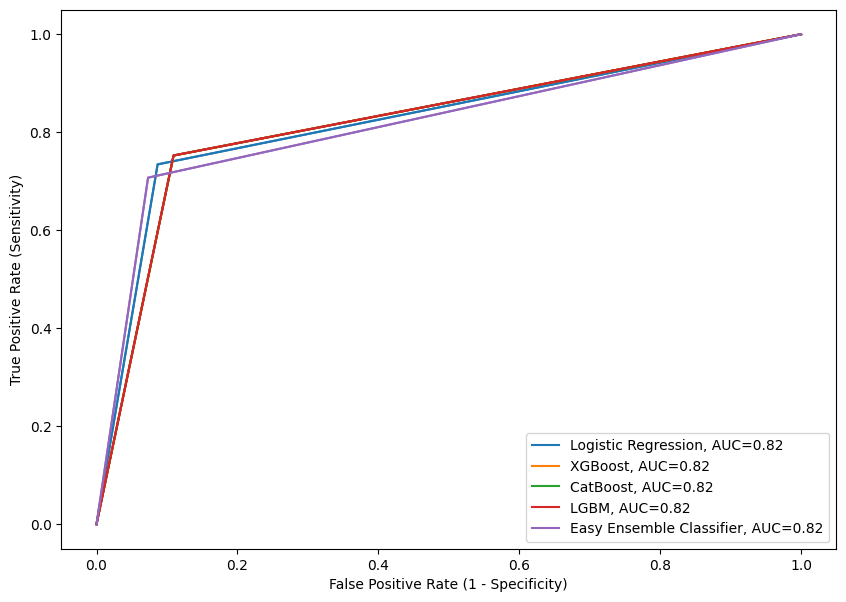

In [ ]:
plt.figure(0, figsize=(10, 7)).clf()

colors = [
    '#1f77b4',  # biru
    '#ff7f0e',  # jingga
    '#2ca02c',  # hijau
    '#d62728',  # merah
    '#9467bd',  # ungu
    '#8c564b',  # coklat
    '#e377c2',  # pink
    '#7f7f7f',  # abu-abu
    '#bcbd22',  # kuning-hijau
    '#17becf'   # cyan
]

# Logistic Regression
y_pred = lr.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[0], label='Logistic Regression, AUC='+str(auc))

# XGBoost
y_pred = xgb.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[1], label='XGBoost, AUC='+str(auc))

# CatBoost
y_pred = cat.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[2], label='CatBoost, AUC='+str(auc))

# LGBM
y_pred = light.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[3], label='LGBM, AUC='+str(auc))

# Easy Ensemble Classifier
y_pred = ensem.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
auc = round(metrics.roc_auc_score(y_test, y_pred), 2)
plt.plot(fpr, tpr, color=colors[4], label='Easy Ensemble Classifier, AUC='+str(auc))

plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()
plt.show();

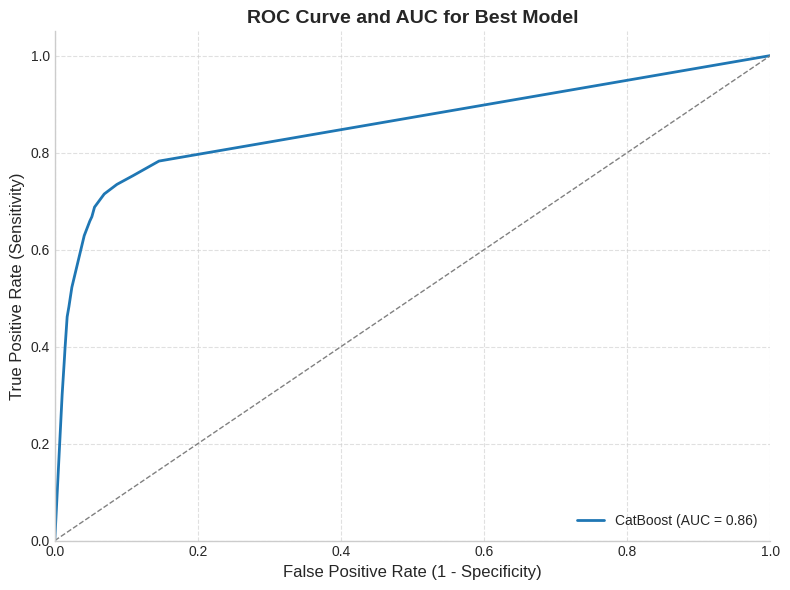

In [ ]:
import matplotlib.pyplot as plt
# Identifikasi model dengan AUC tertinggi
models = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'CatBoost': cat,
    'LGBM': light,
    'Easy Ensemble Classifier': ensem
}

best_model_name = None
best_auc = -1

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Menggunakan probabilitas untuk kurva ROC
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    if auc > best_auc:
        best_auc = auc
        best_model_name = name

# Dapatkan prediksi probabilitas dari model terbaik
best_model = models[best_model_name]
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Hitung nilai FPR, TPR, dan Thresholds untuk kurva ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_best)

# Plot Kurva ROC
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Menggunakan style seaborn yang elegan
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'{best_model_name} (AUC = {best_auc:.2f})') # Garis kurva ROC dengan warna biru dan ketebalan 2
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--') # Garis diagonal

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12) # Font size diperhatikan
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12) # Font size diperhatikan
plt.title('ROC Curve and AUC for Best Model', fontsize=14, fontweight='bold') # Judul dengan font yang menarik
plt.legend(loc="lower right", fontsize=10) # Lokasi legend yang baik
plt.grid(True, linestyle='--', alpha=0.6) # Grid yang minimalis

# Membuat plot lebih minimalis dan elegan
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout() # Menyesuaikan layout agar tidak ada tumpang tindih
plt.show()

### Save Model

In [ ]:
import joblib

# Simpan model terbaik
filename = 'PrabuModel.joblib'
joblib.dump(ensem, filename)

# Kode untuk mengambil (load) model terbaik
loaded_model = joblib.load(filename)